In [1]:
import numpy as np, pandas as pd, scipy, matplotlib.pyplot as plt, seaborn as sns, re, os
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

# Walk the newsgroups directory and append each story to a list of entries
news_stories = []
for folder, subfolders, files in os.walk('/Users/jkovach/Downloads/20_newsgroups/'):
    for file in files:
        filename = folder + '/' + file
        
        with open(filename, encoding = "ISO-8859-1") as story:
            news_story = story.read()
            news_stories.append(news_story)

# This is a hash object (I think), remove it for ease of cleaning
del news_stories[0]

In [2]:
# Clean Text
def text_cleaner(text):
    clean_text = []
    for story in text:
        story = re.sub(r'\S+@\S+', '', story)
        story = re.sub(r'Newsgroups: \S+.', '', story)
        story = re.sub(r'Path: \S+.', '', story)
        #story = re.sub(r'From: \S+\s\S+', '', story)
        story = re.sub(r'Subject: \S+\s\S+', '', story)
        story = re.sub(r'In-Reply-To:', '', story)
        story = re.sub(r'message of', '', story)
        story = re.sub(r'Date:', '', story)
        story = re.sub(r'\S+,\s\d+\s\S+\s\d+\s\d+:\d+:\d+\s\S+', '', story)
        story = re.sub(r'Message-ID:', '', story)
        story = re.sub(r'Sender:', '', story)
        story = re.sub(r'Organization: \S+', '', story)
        story = re.sub(r'References:', '', story)
        story = re.sub(r'Lines: (\d)*', '', story)
        story = re.sub(r'In article \S+\s\S+ writes:', '', story)
        story = re.sub(r'Followup-To:', '', story)
        story = re.sub(r'\S+.{3}:(\d){3,6}', '', story)
        story = re.sub(r'Xref: \S+.', '', story)
        story = re.sub(r'\S+-Posting-Host: \S+', '', story)

        story = ' '.join(story.split())
        clean_text.append(story)
    
    return clean_text

clean_news = text_cleaner(news_stories)
print(clean_news[0:10])

['From: (Harry Mamaysky) of Computer Science, Brown University In article (Brad Hernlem) writes: Lebanese resistance forces detonated a bomb under an Israeli occupation patrol in Lebanese territory two days ago. Three soldiers were killed and two wounded. In "retaliation", Israeli and Israeli-backed forces wounded 8 civilians by bombarding several Lebanese villages. Ironically, the Israeli government justifies its occupation in Lebanon by claiming that it is necessary to prevent such bombardments of Israeli villages!! Congratulations to the brave men of the Lebanese resistance! With every Israeli son that you place in the grave you are underlining the moral bankruptcy of Israel\'s occupation and drawing attention to the Israeli government\'s policy of reckless disregard for civilian life. Brad Hernlem Very nice. Three people are murdered, and Bradly is overjoyed. When I hear about deaths in the middle east, be it Jewish or Arab deaths, I feel sadness, and only hope that soon this all s

In [3]:
# Create Tfidf matrix
vectorizer = TfidfVectorizer(stop_words='english')
news_tfidf = vectorizer.fit_transform(clean_news)

# Get the word list and number of topics
terms = vectorizer.get_feature_names()
ntopics = 5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic
n_top_words = 10

In [4]:
# Using LSA to derive features/topics
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
news_lsa = lsa.fit_transform(news_tfidf)

news_components_lsa = word_topic(news_tfidf, news_lsa, terms)

topwords = pd.DataFrame()
topwords['LSA'] = top_words(news_components_lsa, n_top_words)

In [5]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

news_lda = lda.fit_transform(news_tfidf)
news_components_lda = word_topic(news_tfidf, news_lda, terms)
topwords['LDA'] = top_words(news_components_lda, n_top_words)

In [6]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

news_nmf = nmf.fit_transform(news_tfidf)
news_components_nmf = word_topic(news_tfidf, news_nmf, terms)
topwords['NNMF'] = top_words(news_components_nmf, n_top_words)

In [7]:
# Inspect for relevant words
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                 LSA                LDA            NNMF
0      writes 269.65      writes 287.96     people 7.09
0     article 259.17     article 274.65  government 5.4
0         apr 212.33         don 225.98      writes 5.1
0          don 210.2         apr 225.13        don 4.79
0        just 206.47        just 219.75    article 4.76
0        like 205.45         like 218.9       just 4.46
0         know 197.2      people 216.44       like 3.96
0      people 193.36        know 208.96      think 3.96
0         gmt 192.52         gmt 206.06      right 3.51
0  university 189.82  university 201.17       know 3.39
Topic 1:
              LSA             LDA           NNMF
1   windows 95.19   turkish 11.57  windows 10.12
1    thanks 69.75    writes 10.95     drive 5.93
1     drive 63.61   article 10.92       card 5.5
1      card 58.87   armenian 9.92       dos 5.17
1       dos 48.12        apr 9.72      scsi 4.89
1      mail 47.57  university 9.4       use 4.72
1  software 45.39      

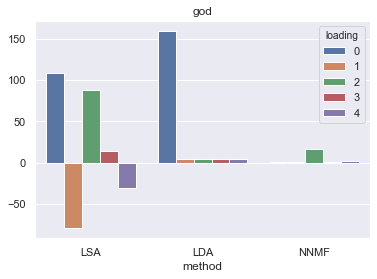

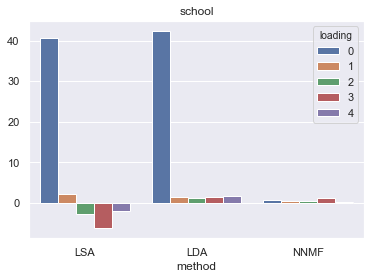

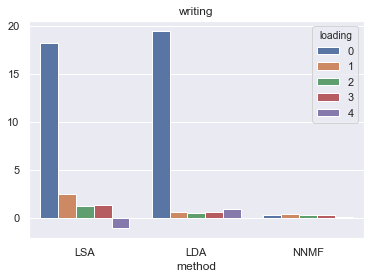

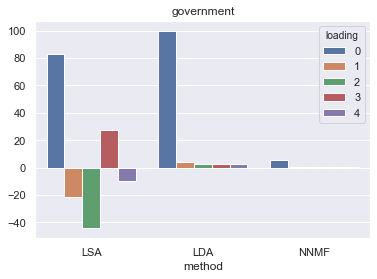

In [15]:
# The words to look at
targetwords = ['god', 'school', 'writing', 'government']

# Store the word loadings
wordloadings = pd.DataFrame(columns=targetwords)

# Extract the string and loading for each word for each method
for word in targetwords:
    loadings = news_components_lsa.loc[word].append(
        news_components_lda.loc[word]).append(
            news_components_nmf.loc[word])
    wordloadings[word] = loadings
    
# Label data by method
wordloadings['method'] = np.repeat(['LSA', 'LDA', 'NNMF'], 5, axis=0)
wordloadings['loading'] = [0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x='method', y=word, hue='loading', data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()